### Data Wrangling 

In [2]:
# Imports
import glob
import shutil
from pathlib import Path

import kagglehub

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Download

In [3]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


### 2. Data re-structuring

Right now, the data exists in a set of numbered directories, one for each patient. In each patient directory there are two sub-directories `0` and `1` containing IDC negative and IDC positive images. We need to collect all of the IDC negative images and IDC positive images into their own directories.

In [5]:
# Get a list of patient directories
patients=glob.glob(f'{path}/*')

# Set up target directories for file copy
idc_negative_directory='../data/idc_negative/'
idc_positive_directory='../data/idc_positive/'

Path(idc_negative_directory).mkdir(parents=True, exist_ok=True)
Path(idc_positive_directory).mkdir(parents=True, exist_ok=True)

# Loop on the patient directories and copy the '0' images to
# the idc_negative directory and the '1' images to the
# idc_positive directory
for patient in patients:

    # Copy the idc negative images from this patient
    idc_negative_images=glob.glob(f'{patient}/0/*.png')

    for image in idc_negative_images:
        shutil.copy(image, idc_negative_directory)

    # Copy the idc positive images from this patient
    idc_positive_images=glob.glob(f'{patient}/1/*.png')

    for image in idc_positive_images:
        shutil.copy(image, idc_positive_directory)

KeyboardInterrupt: 

### EDA

In [4]:
idc_negative_count = len(glob.glob(f'{idc_negative_directory}/*.png'))
idc_positive_count = len(glob.glob(f'{idc_positive_directory}/*.png'))

print(f"IDC Negative Images: {idc_negative_count}")
print(f"IDC Positive Images: {idc_positive_count}")

NameError: name 'idc_negative_directory' is not defined

In [ ]:
from tensorflow.keras.preprocessing import image

# Visualize IDC Negative and Positive Images Side-by-Side
negative_images = glob.glob(f'{idc_negative_directory}/*.png')[:3]
positive_images = glob.glob(f'{idc_positive_directory}/*.png')[:3]

fig, axs = plt.subplots(3, 2, figsize=(6, 6))  # Adjusted figsize for clarity
for neg_img, pos_img, row in zip(negative_images, positive_images, axs):
    for img_path, ax in zip([neg_img, pos_img], row):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        img /= 255.0  # Normalize image values
        ax.imshow(img)
        ax.axis('off')

plt.suptitle("IDC Negative (Left) vs. Positive (Right)")
plt.tight_layout()
plt.show()

In [ ]:
def plot_sample_images(directory, title, num_images=9):
    images = glob.glob(f"{directory}/*.png")
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:min(num_images, len(images))]):
        img = plt.imread(images[i])
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_sample_images(idc_negative_directory, "IDC Negative Samples")
plot_sample_images(idc_positive_directory, "IDC Positive Samples")

In [ ]:
data_summary = pd.DataFrame({
    "Class": ["IDC Negative", "IDC Positive"],
    "Image Count": [idc_negative_count, idc_positive_count]
})
print(data_summary)

In [ ]:
# Check for class imbalance
total_images = idc_negative_count + idc_positive_count
print(f"Class Distribution:\n{data_summary}")
print(f"IDC Negative: {idc_negative_count / total_images:.2%}, IDC Positive: {idc_positive_count / total_images:.2%}")
if abs(idc_negative_count - idc_positive_count) / total_images > 0.2:
    print("Warning: Potential class imbalance detected.")

### Prepare Image Dataset

In [9]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=32):
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    )
    return training_dataset, validation_dataset

image_dim = 128
batch_size = 32
training_dataset, validation_dataset = make_datasets('../data/', image_dim, batch_size)

Found 277524 files belonging to 2 classes.
Using 222020 files for training.


2025-01-14 01:23:02.291838: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 277524 files belonging to 2 classes.
Using 55504 files for validation.


### Sample Model

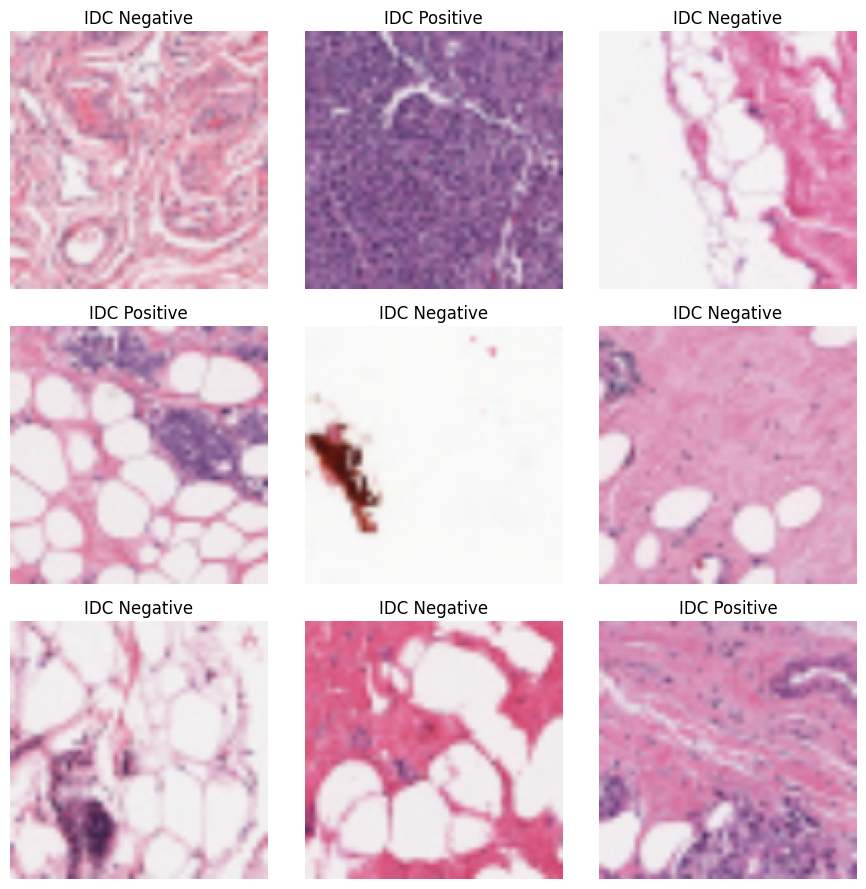

In [10]:
def visualize_images(dataset, class_names):
    images, labels = next(iter(dataset))
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axs.flat[:images.shape[0]]):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[int(labels[i])])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['IDC Negative', 'IDC Positive']
visualize_images(training_dataset, class_names)

### define the model

In [11]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_dim, image_dim, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

/home/vscode/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Train the model

In [ ]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=10,
    steps_per_epoch=len(training_dataset),
    validation_steps=len(validation_dataset)
)

Epoch 1/10


2025-01-14 01:24:34.348850: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-01-14 01:24:34.688854: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30482432 exceeds 10% of free system memory.
2025-01-14 01:24:34.926546: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23482368 exceeds 10% of free system memory.
2025-01-14 01:24:35.043392: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30482432 exceeds 10% of free system memory.
2025-01-14 01:24:35.088755: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25719552 exceeds 10% of free system memory.


2433/6939 ━━━━━━━━━━━━━━━━━━━━ 40:53 545ms/step - accuracy: 0.7018 - loss: 2.3197

### Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

### Training History

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history)